## Import All Package Dependencies

In [97]:
pip install yellowbrick

In [98]:
# Initial processing and visualization related
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
import missingno as msn
import plotly.express as px
from yellowbrick.classifier import ClassPredictionError

# Data processing and transforming
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import LabelEncoder

# Model development related
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

#Model evaluation related
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, ConfusionMatrixDisplay, f1_score, recall_score
from sklearn.model_selection import cross_validate

# Colab-related/file management
from google.colab import drive
from google.colab import files
import os, zipfile, shutil

## Data Loading

In [99]:
# Mount google drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [100]:
# Read dataset
heart = pd.read_csv('/content/drive/MyDrive/Datasets/heart.csv')
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## Exploratory Data Analysis

Check dataset basic info

In [101]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Describe statistics of dataset

In [102]:
heart.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


From the table above we can see that cholesterol and restingBP which are a numerical feature have min value of 0.  Meanwhile resting blood pressure are measured in [mm Hg] while cholesterol are measured [mm/dl] so there is no way their value can be 0.  So we must handle these missing value.

In [103]:
# Check sum of missing value

rbp = (heart.RestingBP == 0).sum()
cho = (heart.Cholesterol == 0).sum()

print('Value 0 in RestingBP column: ', rbp)
print('Value 0 in Cholesterol column: ', cho)

Value 0 in RestingBP column:  1
Value 0 in Cholesterol column:  172


In [104]:
heart.loc[(heart['RestingBP']==0)]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


There is only 1 missing value on RestingBP column so we can just drop it, but there is so much missing value on Cholesterol column while the count of dataset itself is not that much (less than 1000) so every data count and we can fill the missing value using mean from all data.

In [105]:
# Drop missing value in RestingBP row
heart = heart.loc[(heart[['RestingBP']]!=0).all(axis=1)]
heart.shape

(917, 12)

In [106]:
# Fill missing value in Cholesterol column with mean
heart['Cholesterol'].replace(0, heart['Cholesterol'].mean(axis=0), inplace=True)

# Recheck if the 0 value have been handled
cho2 = (heart.Cholesterol == 0).sum()
print('Value 0 in Cholesterol column: ', cho2)

Value 0 in Cholesterol column:  0


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Handle Outliers
Detect outliers in some of the numerical feature such as resting bp, cholesterol, max HR, and old peak using boxplot

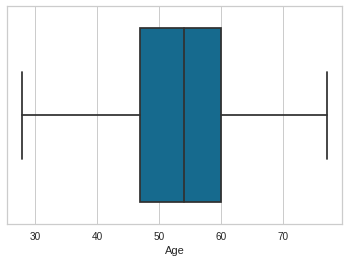

In [107]:
# Age Feature
sns.boxplot(x=heart['Age'])

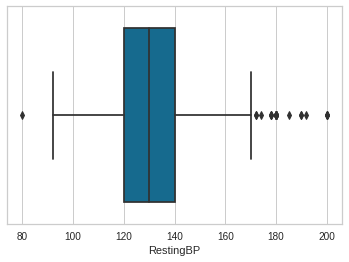

In [108]:
# Resting Blood Pressure Feature
sns.boxplot(x=heart['RestingBP'])

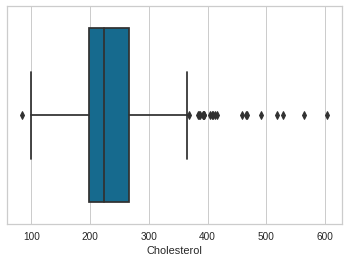

In [109]:
# Cholesterol Feature
sns.boxplot(x=heart['Cholesterol'])

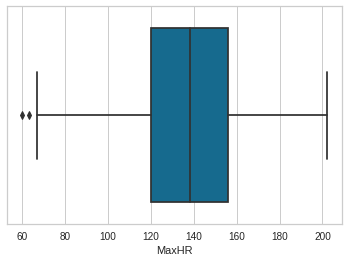

In [110]:
# Maximum Heart Rate Achieved Feature
sns.boxplot(x=heart['MaxHR'])

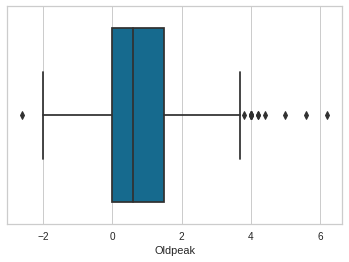

In [111]:
# Oldpeak Feature
sns.boxplot(x=heart['Oldpeak'])

Use IQR Method to remove the outliers

In [112]:
Q1 = heart.quantile(0.25)
Q3 = heart.quantile(0.75)


IQR=Q3-Q1
heart=heart[~((heart<(Q1-1.5*IQR))|(heart>(Q3+1.5*IQR))).any(axis=1)]

# Check dataset size after drop outliers
heart.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning:

Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`



(657, 12)

## Univariate Analysis
We do univariate analysis to each variable as their own data

The Attributess include:
- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

Split categorical features and numerical features so we can analyze them with univariate method

In [113]:
categorical_features = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

### Categorical Exploratory

In [114]:
 # Define functions to analyze categorical data
def analysis_categorical(categorical_features):
  feature = categorical_features
  count = heart[feature].value_counts()
  percent = 100*heart[feature].value_counts(normalize=True)
  df = pd.DataFrame({'Sample count':count, 'percentage':percent.round(1)})
  print(df)
  count.plot(kind='bar', title=feature)

   Sample count  percentage
M           505        76.9
F           152        23.1


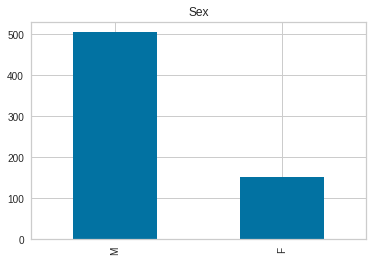

In [115]:
# Sex Features
analysis_categorical(categorical_features[0])

From the graphic above we can see that this feature is pretty imbalanced because 76.9% of the dataset are categorized as Male and may make the models biased.

     Sample count  percentage
ASY           321        48.9
NAP           157        23.9
ATA           148        22.5
TA             31         4.7


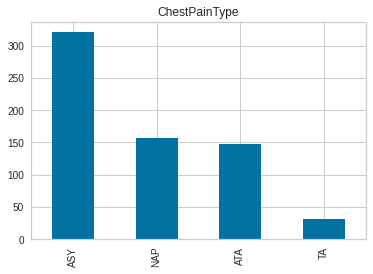

In [116]:
# Chest Pain Type
analysis_categorical(categorical_features[1])

The chest pain type are classified as follow: [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]

And from the graphic above we can conclude that many of the sample in the dataset dont have a symptoms.

   Sample count  percentage
0           657       100.0


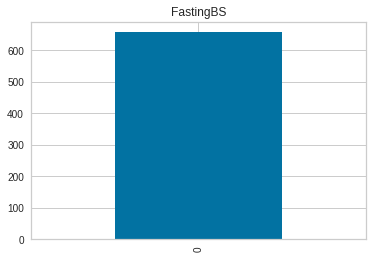

In [117]:
# Fasting Blood Sugar
analysis_categorical(categorical_features[2])

The fasting Blood sugar are supposed to be a categorical feature which composed of 1 if FastingBS > 120mg/dl, and 0 if otherwise.  But it seems all of the data for 1 is being cleaned and only data of FastingBS < 120mg/dl remains.  So this is just a one-sided data and pretty much imbalanced.  So we can drop this column

In [118]:
# Drop FastingBS Column

del heart['FastingBS']
heart

,Age,Sex,ChestPainType,RestingBP,Cholesterol,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289.0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180.0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283.0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214.0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195.0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...
912,57,F,ASY,140,241.0,Normal,123,Y,0.2,Flat,1
913,45,M,TA,110,264.0,Normal,132,N,1.2,Flat,1
915,57,M,ASY,130,131.0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236.0,LVH,174,N,0.0,Flat,1


        Sample count  percentage
Normal           413        62.9
LVH              137        20.9
ST               107        16.3


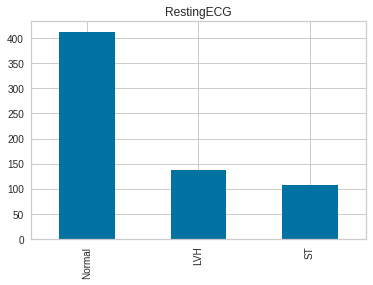

In [119]:
# Resting Electrocargiogram Result
analysis_categorical(categorical_features[3])

The resting electrocardiogram result are classified as follow: [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]

And from the graphic above we can see that most of the samples have normal result

   Sample count  percentage
N           409        62.3
Y           248        37.7


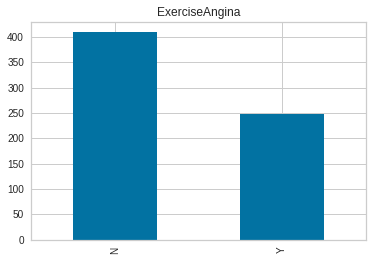

In [120]:
# Exercise Included Angina
analysis_categorical(categorical_features[4])

From the graphic above we can see that there are more samples that dont have included angina on exercise.

      Sample count  percentage
Up             321        48.9
Flat           306        46.6
Down            30         4.6


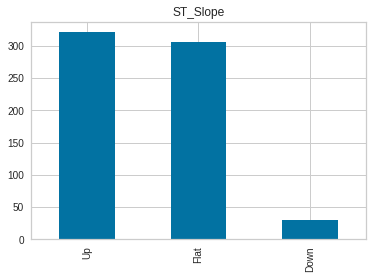

In [121]:
# Exercise ST Slope
analysis_categorical(categorical_features[5])

The ST Slope feature means the slope of the peak exercise ST segment and classified as follow: [Up: upsloping, Flat: flat, Down: downsloping]

And from the graphic above we can see that the samples are balance on the upsloping and flat while there is a few samples which are downsloping

### Numerical Exploratory


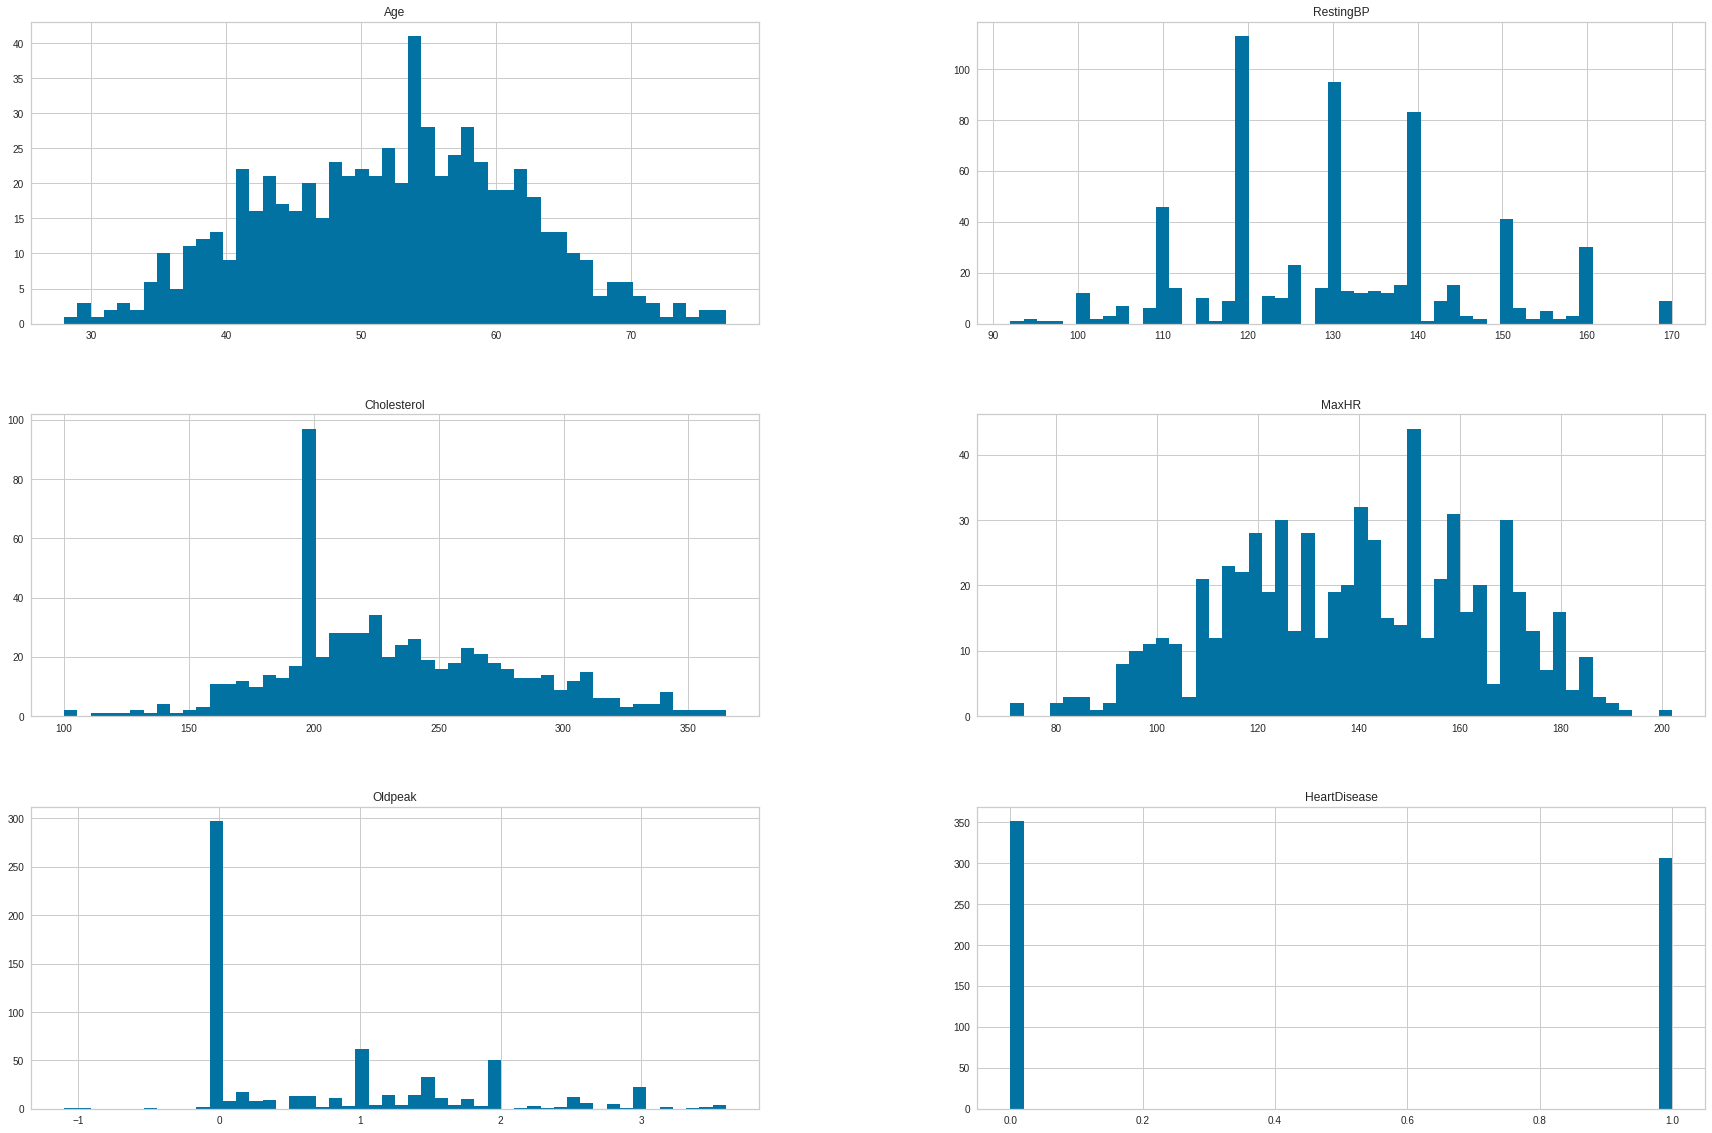

In [122]:
# See histogram of each numerical feature
heart.hist(bins=50, figsize=(30, 20))
plt.show()

From the histogram above we can get some information such as:
1. Many of the age demography are between 40-60 and reach it peaks around 55.
2. The number between sample who get heart disease and not are approximately equal which means the label are balance
3. Most of the sample have 0 value in oldpeak feature which mean it doesnt really related to depression, because this feature is a measurement for depression
4. Many of the serum cholesterol sample are above 200mm/dl while according to some article the ideal serum cholesterol are below 200mm/dl


### Check linearity of variable to look for skewness of overall features

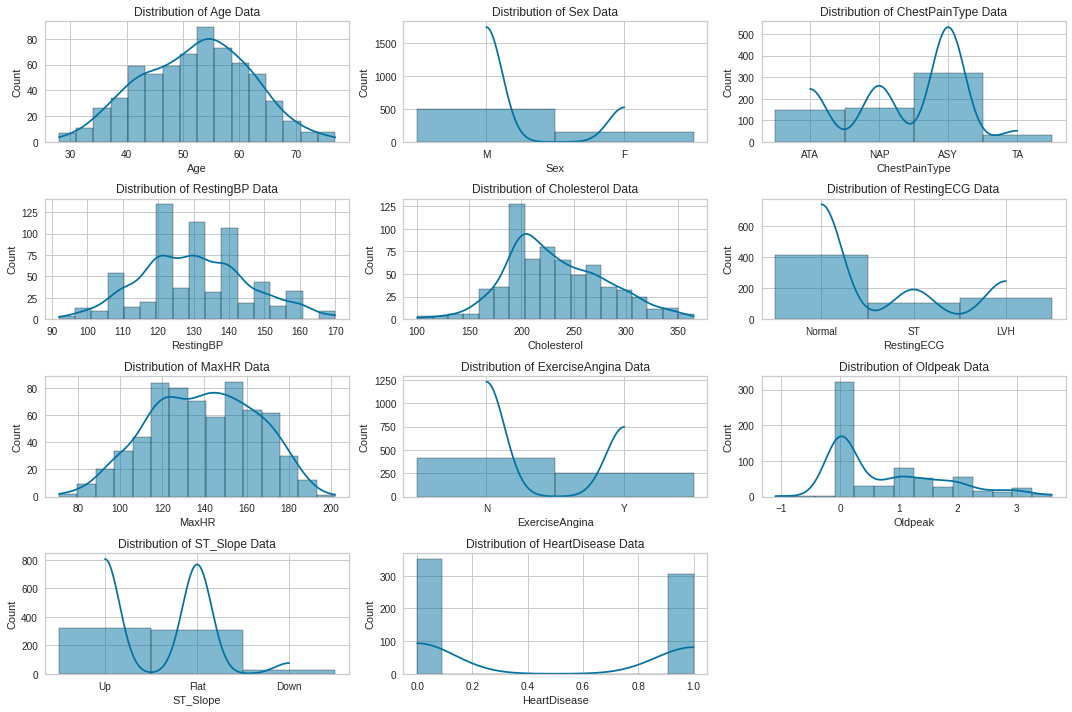

In [123]:
plt.figure(figsize=(15,10))
for i,col in enumerate(heart.columns,1):
    plt.subplot(4,3,i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(heart[col],kde=True)
    plt.tight_layout()
    plt.plot()

## Multivariate Analysis
We do multivariate analysis to know the relation between 2 or more variable

### Categorical Feature Exploratory

In [124]:
# See distribution of categorical column to heart disease
cat_features = heart.select_dtypes(include='object').columns.to_list()

for col in cat_features:
  fig=px.histogram(heart, 
                 x="HeartDisease",
                 color=col,
                 hover_data=heart.columns,
                 title="Distribution of Heart Diseases to - {}".format(col),
                 barmode="group", 
                 text_auto=True)
  fig.show()

From these graphs plot we get some insight such as:
1. There are large margin ration between male to female who got heart diseases.So we can conclude male are more prone to heart diseases than female.
2. Most of people who got heart diseases dont have a symptomps.
3. Most of people who got heart diseases have normal resting ECG result, but many people who also got normal resting ECG result also dont have a heart diseases.  We can conclude this feature doesn't realy contribute much to heart diseases.
4. People who have exercise-included angina are more prone to heart diseases.
5. Most of people who got heart disease have flat st segment result.
6. From above insights we can see a certain pattern for people who got heart diseases and feature that dont really contribute to hert diseases.

Based on the conclusion above we can drop the resting ecg column

In [125]:
# Drop resting ecg column
del heart['RestingECG']
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289.0,172,N,0.0,Up,0
1,49,F,NAP,160,180.0,156,N,1.0,Flat,1
2,37,M,ATA,130,283.0,98,N,0.0,Up,0
3,48,F,ASY,138,214.0,108,Y,1.5,Flat,1
4,54,M,NAP,150,195.0,122,N,0.0,Up,0


### Numerical Feature Exploratory

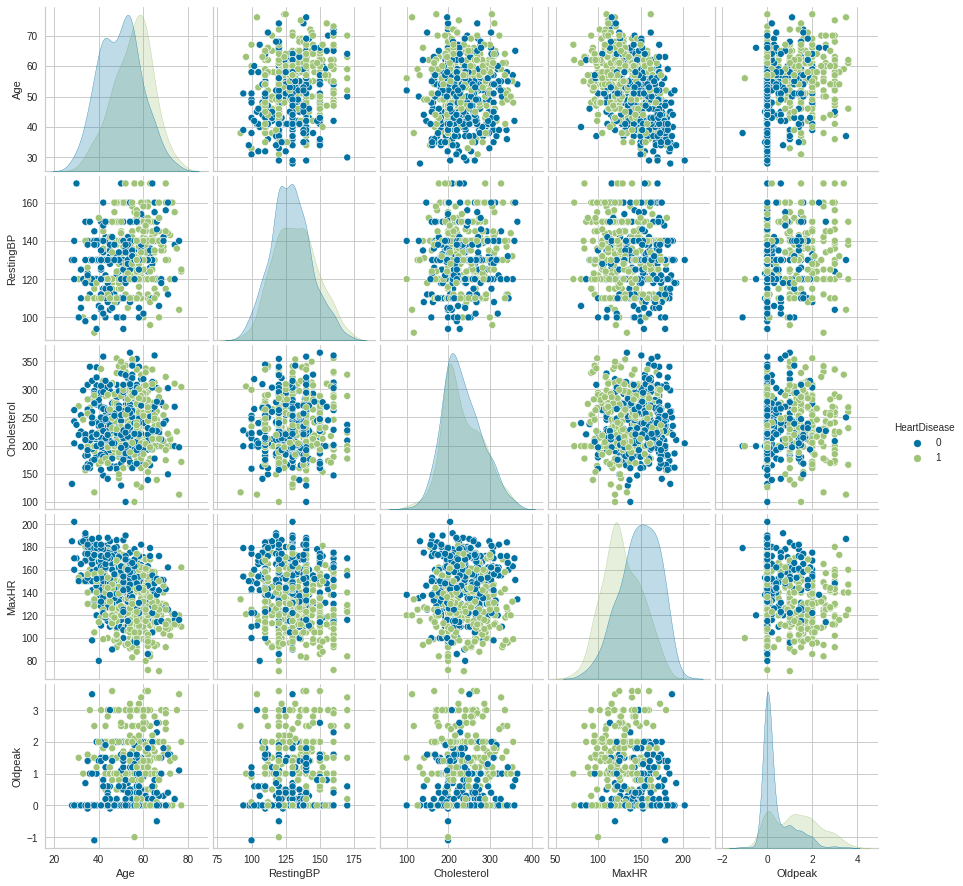

In [126]:
# Use pair plot to analyze relation between numeric feature
sns.pairplot(heart, diag_kind = 'kde', hue='HeartDisease')

### See Correlation Matrix

Text(0.5, 1.0, 'Correlation matrix for numeric feature')

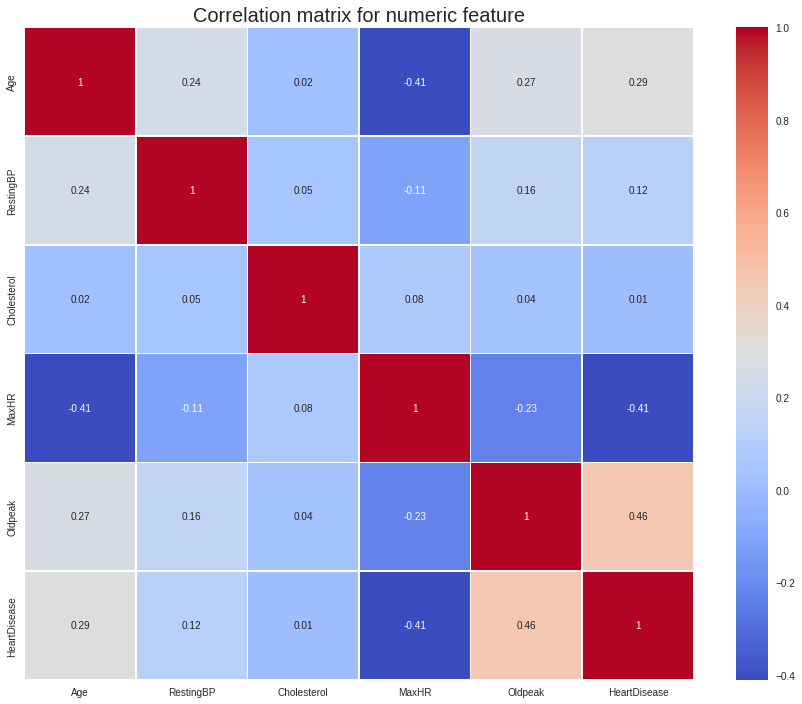

In [127]:
plt.figure(figsize=(15, 12))
correlation_matrix = heart.corr().round(2)

# To print the value inside the box we set the param annot=True
sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidth=0.5, )
plt.title("Correlation matrix for numeric feature", size=20)

From the correlation matrix above we can see that serum cholesterol has very little correlation value to heart disease (near 0) so we can drop it.  And we can see that MaxHR has a high negative correlation with heart diseases.

In [128]:
# Drop the cholesterol column
# heart.drop(['Cholesterol'], inplace=True, axis=1)

In [129]:
# See data after EDA
# heart.head()

## Data Preparation

### Handling Categorical Features
We will use label encoding to handle the categorical features

In [130]:
# Turn categorical column into string
string_col = heart.select_dtypes(include="object").columns
heart[string_col]=heart[string_col].astype("string")

In [131]:
# Get categorical column
string_col=heart.select_dtypes("string").columns.to_list()

In [132]:
# Check data types of dataset
heart.dtypes

Age                 int64
Sex                string
ChestPainType      string
RestingBP           int64
Cholesterol       float64
MaxHR               int64
ExerciseAngina     string
Oldpeak           float64
ST_Slope           string
HeartDisease        int64
dtype: object

In [133]:
# See the distribution of categorical column
heart[string_col].head()
for col in string_col:
    print(f"The distribution of categorical valeus in the {col} is : ")
    print(heart[col].value_counts())

The distribution of categorical valeus in the Sex is : 
M    505
F    152
Name: Sex, dtype: Int64
The distribution of categorical valeus in the ChestPainType is : 
ASY    321
NAP    157
ATA    148
TA      31
Name: ChestPainType, dtype: Int64
The distribution of categorical valeus in the ExerciseAngina is : 
N    409
Y    248
Name: ExerciseAngina, dtype: Int64
The distribution of categorical valeus in the ST_Slope is : 
Up      321
Flat    306
Down     30
Name: ST_Slope, dtype: Int64


In [134]:
# Apply label incoding into dataset
new_df = heart.apply(LabelEncoder().fit_transform)

In [135]:
new_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,12,1,1,33,140,88,0,4,2,0
1,21,0,2,47,33,72,0,14,1,1
2,9,1,1,23,135,15,0,4,2,0
3,20,0,0,31,66,24,1,19,1,1
4,26,1,2,41,46,38,0,4,2,0


### Train Test Split
Split train and test into 80 : 20

In [136]:
X = new_df.drop(['HeartDisease'], axis=1)
y = new_df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

In [137]:
# See data train
X_train.sample()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
137,11,1,1,15,93,62,0,24,2


In [138]:
# Check each sample of splitted data
print(f'Total # of sample in whole dataset: {len(X)}')
print(f'Total # of sample in train dataset: {len(X_train)}')
print(f'Total # of sample in test dataset: {len(X_test)}')

Total # of sample in whole dataset: 657
Total # of sample in train dataset: 525
Total # of sample in test dataset: 132


### Standardization

In [139]:
numerical_features = ['Age', 'RestingBP', 'MaxHR', 'Oldpeak']
scaler = StandardScaler()
scaler.fit(X_train[numerical_features])
X_train[numerical_features] = scaler.transform(X_train.loc[:, numerical_features])
X_train[numerical_features].head()

,Age,RestingBP,MaxHR,Oldpeak
285,-0.082427,-1.220688,-0.817948,-0.822745
83,0.022863,1.911245,0.996854,-0.822745
712,0.654602,-1.728569,0.633894,-0.716721
680,0.549312,1.403364,-1.140579,-0.186602
119,-1.872354,0.726189,1.601788,-0.822745


In [140]:
# Check data after standardization
X_train[numerical_features].describe().round(4)

,Age,RestingBP,MaxHR,Oldpeak
count,525.0000,525.0000,525.0000,525.0000
mean,-0.0000,-0.0000,0.0000,-0.0000
std,1.0010,1.0010,1.0010,1.0010
min,-2.5041,-2.0672,-2.2698,-1.2468
25%,-0.7142,-0.7975,-0.8179,-0.8227
50%,0.0229,-0.1203,-0.0114,-0.6107
75%,0.7599,0.7262,0.7952,0.7676
max,2.6551,1.9959,2.0051,2.6760


## Base Model Development

We will try to use tree based model in order to solve this classification problem such as decision tree, random forest, and XG Boost

## Decision Tree

### Modelling Base Decision Tree 

In [141]:
DT = DecisionTreeClassifier(class_weight="balanced", criterion="entropy", random_state=101)
DT.fit(X_train, y_train)
y_pred = DT.predict(X_test)

### Model Evaluation for DT

In [142]:
# First we need to scale data test
X_test.loc[:, numerical_features] = scaler.transform(X_test[numerical_features])

In [143]:
# Def function for model evaluation
def evaluate(y_test, y_pred):
  print(classification_report(y_test, y_pred))
  acc=accuracy_score(y_test, y_pred)
  print(acc)
  print('\nConfusion matrix: \n', confusion_matrix(y_test, y_pred))
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.24      0.32      0.27        63
           1       0.09      0.06      0.07        69

    accuracy                           0.18       132
   macro avg       0.16      0.19      0.17       132
weighted avg       0.16      0.18      0.17       132

0.18181818181818182

Confusion matrix: 
 [[20 43]
 [65  4]]


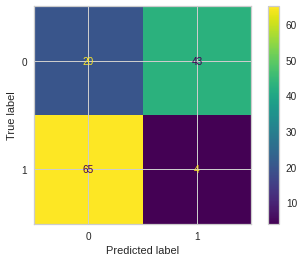

In [144]:
# Model Evaluation
evaluate(y_test, y_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



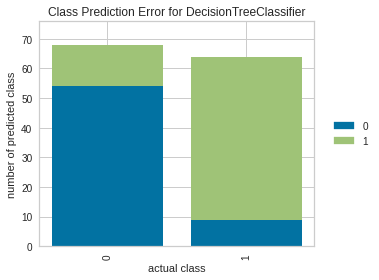

In [145]:
# See class prediction error
visualizer = ClassPredictionError(DT)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

In [146]:
# Cross-Validating Decision Tree (DT)
dt_xvalid_model = DecisionTreeClassifier(max_depth=None, random_state=101)

dt_xvalid_model_scores = cross_validate(dt_xvalid_model, X_train, y_train, scoring = ["accuracy", "recall"], cv = 10)
dt_xvalid_model_scores = pd.DataFrame(dt_xvalid_model_scores, index = range(1, 11))

dt_xvalid_model_scores

,fit_time,score_time,test_accuracy,test_recall
1,0.005132,0.002959,0.811321,0.833333
2,0.003796,0.002824,0.830189,0.750000
3,0.003716,0.002761,0.905660,0.875000
4,0.003755,0.003015,0.754717,0.833333
5,0.005698,0.005887,0.811321,0.750000
6,0.004182,0.003212,0.711538,0.782609
7,0.004178,0.003179,0.769231,0.739130
8,0.003923,0.003140,0.711538,0.652174
9,0.004074,0.003312,0.788462,0.708333
10,0.004080,0.003326,0.826923,0.833333


In [147]:
# See average validation score
dt_xvalid_model_scores.mean()

fit_time         0.004254
score_time       0.003362
test_accuracy    0.792090
test_recall      0.775725
dtype: float64

### Modelling Decision Tree Using Grid Search

In [148]:
# Define parameter grid
param_grid = {"criterion":["gini", "entropy"],
              "splitter":["best", "random"],
              "max_depth": [None, 3, 6, 9, 12],
              "max_features":[None, 3, 5, 7],
              "min_samples_leaf": [2, 3, 4],
              "min_samples_split": [2, 3, 5, 7, 9, 12]}

In [149]:
# Iniate new model for grid search
DT_grid = DecisionTreeClassifier(class_weight = "balanced", random_state=101)
DT_grid = GridSearchCV(estimator=DT_grid,
                            param_grid=param_grid,
                            scoring='recall',
                            n_jobs = -1,
                            verbose = 2).fit(X_train, y_train)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


              precision    recall  f1-score   support

           0       0.78      0.75      0.76        63
           1       0.78      0.81      0.79        69

    accuracy                           0.78       132
   macro avg       0.78      0.78      0.78       132
weighted avg       0.78      0.78      0.78       132

0.7803030303030303

Confusion matrix: 
 [[47 16]
 [13 56]]


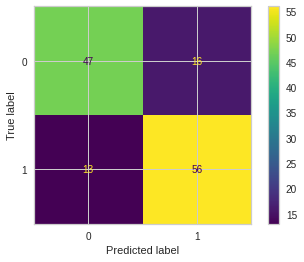

In [150]:
# Evaluate model after grid search
y_pred = DT_grid.best_estimator_.predict(X_test)
evaluate(y_test, y_pred)

# Save score for later comparison
dt_grid_acc = accuracy_score(y_test, y_pred)
dt_grid_recall = recall_score(y_test, y_pred)

### Feature Importance for Decision Tree Model

In [151]:
DT_grid.best_estimator_.feature_importances_

array([0.04134312, 0.0696293 , 0.08027353, 0.03428639, 0.02351458,
       0.05253937, 0.19966991, 0.27858959, 0.22015421])

In [152]:
# Define df for feature importances
DT_feature_imp = pd.DataFrame(index=X.columns, data = DT_grid.best_estimator_.feature_importances_,
                      columns = ["Feature Importance"]).sort_values("Feature Importance")
DT_feature_imp

,Feature Importance
Cholesterol,0.023515
RestingBP,0.034286
Age,0.041343
MaxHR,0.052539
Sex,0.069629
ChestPainType,0.080274
ExerciseAngina,0.199670
ST_Slope,0.220154
Oldpeak,0.278590


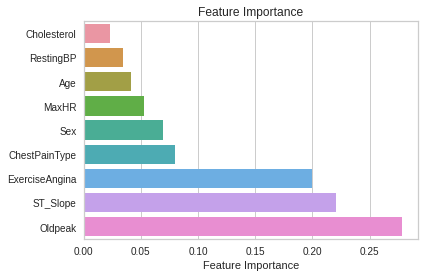

In [153]:
# Plot feature importances
sns.barplot(x=DT_feature_imp["Feature Importance"], y=DT_feature_imp.index)
plt.title("Feature Importance")
plt.show()

## Random Forest

### Modelling Base Random Forest 

In [154]:
RF = RandomForestClassifier(class_weight="balanced", criterion='entropy', random_state=101)
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)

### Model Evaluation for RF


              precision    recall  f1-score   support

           0       0.83      0.79      0.81        63
           1       0.82      0.86      0.84        69

    accuracy                           0.83       132
   macro avg       0.83      0.82      0.82       132
weighted avg       0.83      0.83      0.83       132

0.8257575757575758

Confusion matrix: 
 [[50 13]
 [10 59]]


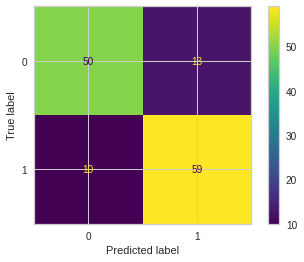

In [155]:
# Model Evaluation
evaluate(y_test, y_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



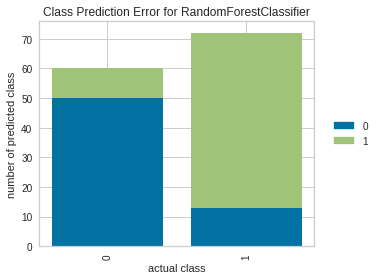

In [156]:
# See class prediction error
visualizer = ClassPredictionError(RF)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

In [157]:
# Cross-Validating Random Forest (RF)
rf_xvalid_model = RandomForestClassifier(max_depth=None, random_state=101)

rf_xvalid_model_scores = cross_validate(rf_xvalid_model, X_train, y_train, scoring = ["accuracy", "recall"], cv = 10)
rf_xvalid_model_scores = pd.DataFrame(rf_xvalid_model_scores, index = range(1, 11))

rf_xvalid_model_scores

,fit_time,score_time,test_accuracy,test_recall
1,0.190949,0.022055,0.849057,0.875000
2,0.193741,0.017775,0.811321,0.666667
3,0.187759,0.019286,0.849057,0.791667
4,0.183368,0.018153,0.792453,0.916667
5,0.178507,0.026964,0.924528,0.875000
6,0.183759,0.018357,0.826923,0.826087
7,0.192386,0.021034,0.923077,0.956522
8,0.186548,0.018406,0.769231,0.739130
9,0.186148,0.022307,0.807692,0.708333
10,0.183167,0.019007,0.826923,0.791667


In [158]:
# See average validation score
rf_xvalid_model_scores.mean()

fit_time         0.186633
score_time       0.020334
test_accuracy    0.838026
test_recall      0.814674
dtype: float64

### Modelling Random Forest Using Grid Search

In [159]:
# Define param grid
param_grid = {'criterion':['gini', 'entropy'],
             'n_estimators':[100, 200, 300],
             'max_features':[3, 4, 5],
             'max_depth':[3, 5, 7, 9],
             'min_samples_split':[2, 5, 8]}

In [160]:
# Iniate new model for grid search
RF_grid = RandomForestClassifier(class_weight="balanced", random_state=101)

RF_grid = GridSearchCV(estimator=RF_grid, 
                       param_grid=param_grid, 
                       scoring = "recall", 
                       n_jobs = -1, 
                       verbose = 2).fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


              precision    recall  f1-score   support

           0       0.82      0.81      0.82        63
           1       0.83      0.84      0.83        69

    accuracy                           0.83       132
   macro avg       0.83      0.83      0.83       132
weighted avg       0.83      0.83      0.83       132

0.8257575757575758

Confusion matrix: 
 [[51 12]
 [11 58]]


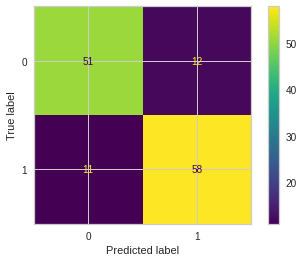

In [161]:
# Evaluate model after grid search
y_pred = RF_grid.best_estimator_.predict(X_test)
evaluate(y_test, y_pred)

# Save score for later comparison
rf_grid_acc = accuracy_score(y_test, y_pred)
rf_grid_recall = recall_score(y_test, y_pred)

### Feature Importance for Random Forest Model

In [162]:
RF_grid.best_estimator_.feature_importances_

array([0.02867046, 0.04857076, 0.18232638, 0.01709505, 0.01104855,
       0.06151218, 0.11338638, 0.08882042, 0.44856982])

In [163]:
# Define RF feature importances
RF_feature_imp = pd.DataFrame(index = X.columns, data = RF_grid.best_estimator_.feature_importances_,
                              columns = ["Feature Importance"]).sort_values("Feature Importance", ascending = False)
RF_feature_imp

,Feature Importance
ST_Slope,0.448570
ChestPainType,0.182326
ExerciseAngina,0.113386
Oldpeak,0.088820
MaxHR,0.061512
Sex,0.048571
Age,0.028670
RestingBP,0.017095
Cholesterol,0.011049


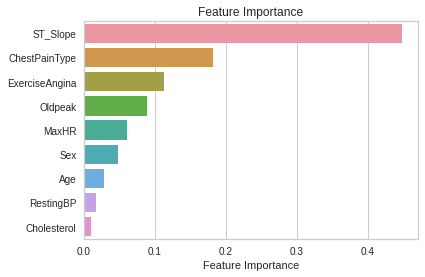

In [164]:
# Plot feature importances
sns.barplot(x=RF_feature_imp["Feature Importance"], y=RF_feature_imp.index)
plt.title("Feature Importance")
plt.show()

Compare the feature importance result with the decision tree one

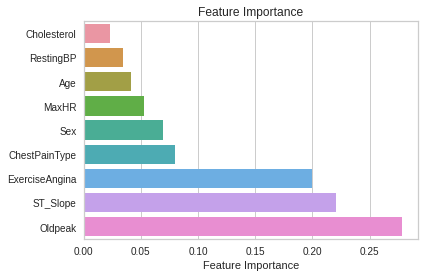

In [165]:
sns.barplot(x=DT_feature_imp["Feature Importance"], y=DT_feature_imp.index)
plt.title("Feature Importance")
plt.show()

## XGBoost

### Modelling base XGBoost

In [166]:
XGB = XGBClassifier(random_state=101)
XGB.fit(X_train, y_train)
y_pred = XGB.predict(X_test)

### Model Evaluation for XGBoost

              precision    recall  f1-score   support

           0       0.79      0.79      0.79        63
           1       0.81      0.81      0.81        69

    accuracy                           0.80       132
   macro avg       0.80      0.80      0.80       132
weighted avg       0.80      0.80      0.80       132

0.803030303030303

Confusion matrix: 
 [[50 13]
 [13 56]]


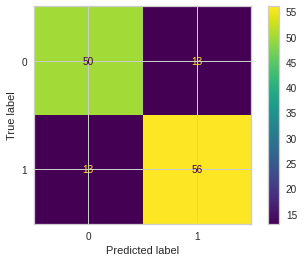

In [167]:
# Model Evaluation
evaluate(y_test, y_pred)

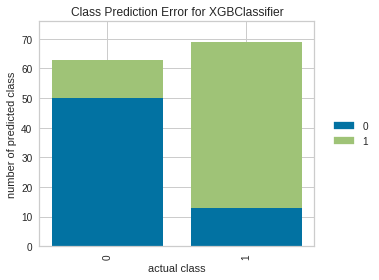

In [168]:
# See class prediction error
visualizer = ClassPredictionError(XGB)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

In [169]:
# Cross-Validating XGBoost
xgb_xvalid_model = XGBClassifier(random_state=101)

xgb_xvalid_model_scores = cross_validate(xgb_xvalid_model, X_train, y_train, scoring = ["accuracy", "recall"], cv = 10)
xgb_xvalid_model_scores = pd.DataFrame(xgb_xvalid_model_scores, index = range(1, 11))

xgb_xvalid_model_scores

,fit_time,score_time,test_accuracy,test_recall
1,0.038487,0.005481,0.867925,0.875000
2,0.040796,0.003200,0.849057,0.791667
3,0.034213,0.003174,0.943396,0.916667
4,0.034293,0.003110,0.886792,0.958333
5,0.042604,0.003126,0.886792,0.833333
6,0.041593,0.003106,0.846154,0.826087
7,0.037433,0.003200,0.903846,0.913043
8,0.033996,0.003143,0.769231,0.782609
9,0.034017,0.003386,0.826923,0.750000
10,0.045533,0.005169,0.865385,0.875000


In [170]:
# See cv avg score
xgb_xvalid_model_scores.mean()

fit_time         0.038297
score_time       0.003609
test_accuracy    0.864550
test_recall      0.852174
dtype: float64

### Modelling XGBoost Using Grid Search

In [171]:
param_grid = {"n_estimators":[100, 200, 300], 
              "max_depth":[3,5,6,7,8], 
              "learning_rate": [0.01, 0.03, 0.1, 0.3],
              "subsample":[0.5, 1], 
              "colsample_bytree":[0.5, 1]}

In [172]:
# Initiate new xgb model for grid search
XGB_grid = XGBClassifier(random_state=100)
XGB_grid = GridSearchCV(XGB_grid,
                        param_grid, 
                        scoring = "recall", 
                        n_jobs=-1,
                        verbose=2).fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


              precision    recall  f1-score   support

           0       0.84      0.76      0.80        63
           1       0.80      0.87      0.83        69

    accuracy                           0.82       132
   macro avg       0.82      0.82      0.82       132
weighted avg       0.82      0.82      0.82       132

0.8181818181818182

Confusion matrix: 
 [[48 15]
 [ 9 60]]


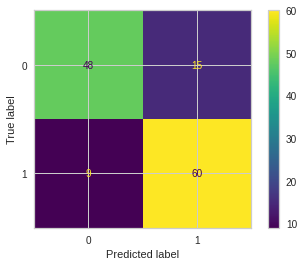

In [173]:
# Evaluate model after grid search
y_pred = XGB_grid.best_estimator_.predict(X_test)
evaluate(y_test, y_pred)

# Save each score for later comparison
xgb_grid_acc = accuracy_score(y_test, y_pred)
xgb_grid_recall = recall_score(y_test, y_pred)

### Feature Importance for XGBoost Model

In [174]:
XGB_grid.best_estimator_.feature_importances_ 

array([0.01920838, 0.09595673, 0.0577566 , 0.02250945, 0.0176964 ,
       0.03435111, 0.03167693, 0.03606171, 0.68478274], dtype=float32)

In [175]:
XGB_feature_imp = pd.DataFrame(index=X.columns, data=XGB_grid.best_estimator_.feature_importances_, columns=["Feature Importance"]) 
XGB_feature_imp = XGB_feature_imp.sort_values("Feature Importance")

XGB_feature_imp 

,Feature Importance
Cholesterol,0.017696
Age,0.019208
RestingBP,0.022509
ExerciseAngina,0.031677
MaxHR,0.034351
Oldpeak,0.036062
ChestPainType,0.057757
Sex,0.095957
ST_Slope,0.684783


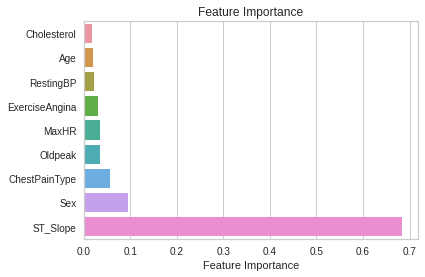

In [176]:
# Plot feature importances
sns.barplot(x=XGB_feature_imp["Feature Importance"], y=XGB_feature_imp.index)
plt.title("Feature Importance")
plt.show()

Compare important features with other models

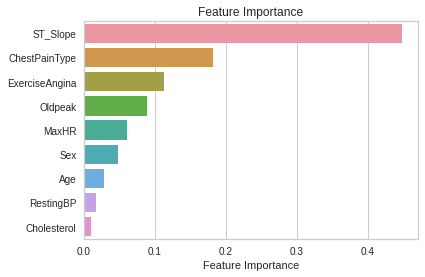

In [177]:
# Random Forest
sns.barplot(x=RF_feature_imp["Feature Importance"], y=RF_feature_imp.index)
plt.title("Feature Importance")
plt.show()

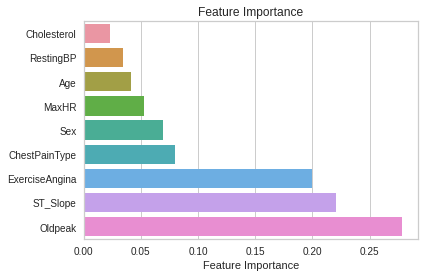

In [178]:
# Decision Tree
sns.barplot(x=DT_feature_imp["Feature Importance"], y=DT_feature_imp.index)
plt.title("Feature Importance")
plt.show()

## Comparing All Model

In [179]:
# Create df for model comparison
compare = pd.DataFrame({'Model': ["Decision Tree", "Random Forest", "XGBoost"],
                        'Recall': [dt_grid_recall, rf_grid_recall, xgb_grid_recall],
                        'Accuracy': [dt_grid_acc, rf_grid_acc, xgb_grid_acc],
                        })

In [180]:
# Def function to set label
def labels(ax):
    for p in ax.patches:
        width = p.get_width()                        # get bar length
        ax.text(width,                               # set the text at 1 unit right of the bar
                p.get_y() + p.get_height() / 2,      # get Y coordinate + X coordinate / 2
                '{:1.3f}'.format(width),             # set variable to display, 2 decimals
                ha = 'left',                         # horizontal alignment
                va = 'center')                       # vertical alignment

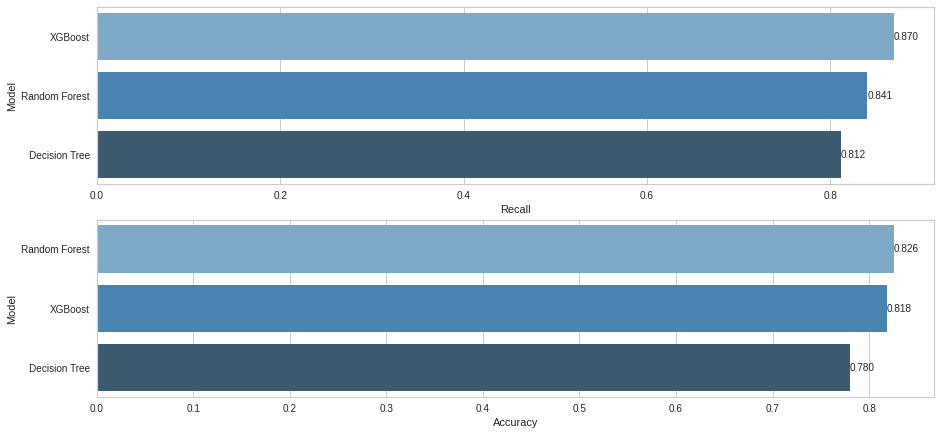

In [181]:
# Plot model comparison    
plt.figure(figsize=(15,15))
plt.subplot(411)
compare = compare.sort_values(by="Recall", ascending=False)
ax=sns.barplot(x="Recall", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.subplot(412)
compare = compare.sort_values(by="Accuracy", ascending=False)
ax=sns.barplot(x="Accuracy", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.show()

## Conclusion
Based on the 3 tree models that we have created, it seems that XGBoost have the best overall accuracy : recall ratio compared to random forest with recall rate of 87% and accuracy of 81%.